In [1]:
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import json
import spacy
import ast
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import os
from collections import defaultdict
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from transformers.utils import logging
logging.set_verbosity_error()  # Suppress warnings from transformers library

import matplotlib.pyplot as plt

%matplotlib inline

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [2]:
with open("tagged_sentences.pkl","rb") as f:
    tagged_sentences = pickle.load(f)

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', device="cuda")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Resize model embeddings to accommodate the new token
model = GPT2LMHeadModel.from_pretrained('gpt2').to("cuda")
model.resize_token_embeddings(len(tokenizer))

Embedding(50258, 768)

In [5]:
def compute_kl_divergence(real_matrix, generated_matrix, epsilon=1e-10):
   '''
   Compute KL divergence between two matrices
   '''
   kl_scores = {}

   for ngram in real_matrix.index:
      if ngram in generated_matrix.index:
         real_probs = real_matrix.loc[ngram].values
         gen_probs = generated_matrix.loc[ngram].values

         real_sum = real_probs.sum()
         gen_sum = gen_probs.sum()

         if real_sum == 0 or gen_sum == 0:
            kl_scores[ngram] = 0.0
            continue

         real_probs = real_probs / real_sum
         gen_probs = gen_probs / gen_sum

         gen_probs = np.clip(gen_probs, epsilon, 1)

         kl_scores[ngram] = entropy(real_probs, gen_probs)
   return kl_scores

In [6]:
def compute_js_divergence(real_matrix, generated_matrix, epsilon=1e-10):
    """
    Compute Jensen-Shannon divergence between real and generated POS probability matrices.
    """
    js_scores = {}

    for ngram in real_matrix.index:
        if ngram in generated_matrix.index:
            real_probs = real_matrix.loc[ngram].values
            gen_probs = generated_matrix.loc[ngram].values

            real_sum = real_probs.sum()
            gen_sum = gen_probs.sum()

            if real_sum == 0 or gen_sum == 0:
              js_scores[ngram] = 0.0
              continue


            real_probs = real_probs / real_sum
            gen_probs = gen_probs / gen_sum

            gen_probs = np.clip(gen_probs, epsilon, 1)

            js_scores[ngram] = jensenshannon(real_probs, gen_probs)

    return js_scores

In [7]:
# We'll use a subset of the tagged sequences for the experiment to reduce computation time
subset_percentage = 0.15
train_size = 0.8
sample_size = int(len(tagged_sentences) * subset_percentage)

sample_tagged_sentences = tagged_sentences[:sample_size]
train_size = int(len(sample_tagged_sentences) * train_size)

train_sentences = sample_tagged_sentences[:train_size]
test_sentences = sample_tagged_sentences[train_size:]

In [8]:
len(train_sentences)

1200

In [9]:
len(test_sentences)

300

In [10]:
MAX_LENGTH = model.config.n_positions

In [ ]:
# Define a function to create a nested defaultdict
def dd():
    return defaultdict(int)
transition_matrix = defaultdict(dd)
gt_transition_matrix = defaultdict(dd)

In [ ]:
# Build transition matrices
for ix, sent in enumerate(train_sentences):
    tokens = [t[0] for t in sent]
    pos = [t[1] for t in sent]
    for i in range(1, len(sent)):
        prefix = " ".join(tokens[:i])
        prefix_pos = "->".join(pos[:i])

        ground_truth_pos = pos[i]

        inputs = tokenizer(prefix, return_tensors="pt")
        if inputs['input_ids'].shape[1] > MAX_LENGTH -1:
            continue # Skip if input is too long
        inputs = inputs.to("cuda")

        with torch.no_grad():
            outputs = model.generate(**inputs,
                                     max_new_tokens=1,
                                     output_scores=True,
                                     return_dict_in_generate=True,
                                     temperature=0.0,
                                     do_sample=False,
                                     pad_token_id=tokenizer.pad_token_id)
            next_token = tokenizer.decode(outputs[0][-1], skip_special_tokens=True).strip()
            del outputs
        pred_doc = nlp(prefix + " " + next_token)
        pred_pos = pred_doc[-1].pos_

        transition_matrix[prefix_pos][pred_pos] += 1
        gt_transition_matrix[prefix_pos][ground_truth_pos] += 1
    print(f"Processed segment {ix + 1}/{len(train_sentences)}")

Processed segment 1/1200
Processed segment 2/1200
Processed segment 3/1200
Processed segment 4/1200
Processed segment 5/1200
Processed segment 6/1200
Processed segment 7/1200
Processed segment 8/1200
Processed segment 9/1200
Processed segment 10/1200
Processed segment 11/1200
Processed segment 12/1200
Processed segment 13/1200
Processed segment 14/1200
Processed segment 15/1200
Processed segment 16/1200
Processed segment 17/1200
Processed segment 18/1200
Processed segment 19/1200
Processed segment 20/1200
Processed segment 21/1200
Processed segment 22/1200
Processed segment 23/1200
Processed segment 24/1200
Processed segment 25/1200
Processed segment 26/1200
Processed segment 27/1200
Processed segment 28/1200
Processed segment 29/1200
Processed segment 30/1200
Processed segment 31/1200
Processed segment 32/1200
Processed segment 33/1200
Processed segment 34/1200
Processed segment 35/1200
Processed segment 36/1200
Processed segment 37/1200
Processed segment 38/1200
Processed segment 39/

In [ ]:
# Normalize the counts to probabilities
for prefix, next_tokens in transition_matrix.items():
    total = sum(next_tokens.values())
    for token, count in next_tokens.items():
        transition_matrix[prefix][token] = count / total if total > 0 else 0

for prefix, gt_tokens in gt_transition_matrix.items():
    total = sum(gt_tokens.values())
    for token, count in gt_tokens.items():
        gt_transition_matrix[prefix][token] = count / total if total > 0 else 0

In [ ]:
# Convert to DataFrame for easier handling
transition_df = pd.DataFrame(transition_matrix).transpose().fillna(0)
gt_transition_df = pd.DataFrame(gt_transition_matrix).transpose().fillna(0)

In [16]:
transition_df.to_csv("generated_transition_matrix_sentence_level.csv", index=False)
gt_transition_df.to_csv("ground_truth_transition_matrix_sentence_level.csv", index=False)

In [17]:
transition_df

,PUNCT,NOUN,PART,PROPN,ADP,ADJ,VERB,PRON,ADV,NUM,CCONJ,AUX,SCONJ,X,SYM,INTJ
PUNCT,0.995192,0.004808,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PUNCT->PROPN,0.375000,0.218750,0.03125,0.343750,0.03125,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PUNCT->PROPN->PUNCT,0.416667,0.083333,0.00000,0.166667,0.00000,0.083333,0.166667,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PUNCT->PROPN->PUNCT->X,0.000000,0.000000,0.00000,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PUNCT->PROPN->PUNCT->X->PUNCT,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROPN->PROPN->PROPN->CCONJ->VERB->DET->DET,0.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PROPN->PROPN->PROPN->CCONJ->VERB->DET->DET->NOUN,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PROPN->PROPN->PROPN->CCONJ->VERB->DET->DET->NOUN->ADP,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PROPN->PROPN->PROPN->CCONJ->VERB->DET->DET->NOUN->ADP->ADJ,0.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Check for any prefixes in ground truth not in generated
set(gt_transition_df.columns) - set(transition_df.columns)

{'DET'}

In [ ]:
# Add missing columns with zero probabilities
transition_df['DET'] = 0.0

In [ ]:
# Reorder columns to match ground truth
columns = sorted(gt_transition_df.columns)
kl_scores = compute_kl_divergence(gt_transition_df[columns], transition_df[columns])
js_scores = compute_js_divergence(gt_transition_df[columns], transition_df[columns])

In [ ]:
# Convert scores to lists for easier analysis
js_values = list(js_scores.values())

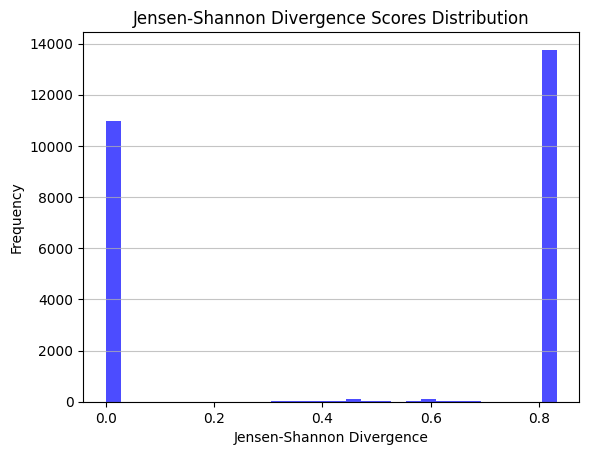

In [22]:
plt.hist(js_values, bins=30, alpha=0.7, color='blue')
plt.title('Jensen-Shannon Divergence Scores Distribution')
plt.xlabel('Jensen-Shannon Divergence')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [23]:
print(f"Mean: {np.mean(list(js_scores.values()))}")
print(f"Median: {np.median(list(js_scores.values()))}")

Mean: 0.46387423473292216
Median: 0.832554610436248


## POS TAG Meanings
* ADJ: Adjective
* ADP: Adposition
* ADV: Adverb
* AUX: Auxiliary
* CONJ: Conjunction
* CCONJ: Coordinating conjunction
* DET: Determiner
* INTJ: Interjection
* NOUN: Noun
* NUM: Numeral
* PART: Particle
* PRON: Pronoun
* PUNCT: Punctuation
* SCONJ: Subordinating conjunction
* SPACE: Space
* SYM: Symbol
* VERB: Verb
* X: Other
* EOL: End of line